In [33]:
from imdb import IMDb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from PIL import Image  
import requests
import io

In [34]:
# create an instance of the IMDb class
imdb = IMDb()

0 tv series Rick and Morty
2013


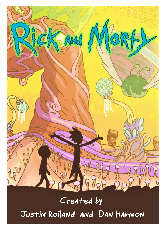

In [40]:
search = 'Rick and Morty'
results = imdb.search_movie(search)


for i in range(len(results[:3])):
        
    if results[i]['kind'] == 'tv series':
        print(i, results[i]['kind'], results[i]['title'])
        try:
            print(results[i]['year'])
        except:
            pass
        # creating a object  
        url = results[i]['full-size cover url']

        response = requests.get(url, stream=True)
        img = Image.open(response.raw)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [41]:
imdb.search_movie(imdb.get_imdbID(results[0]))

[<Movie id:11560114[http] title:_"Mundial Total" Brasil 2014: 24/06/14 (2014)_>]

In [42]:
show = results[0]

try:
    imdb.update(show, info = ['episodes'])
except:
    print("Error 404- Show Episodes not found")

In [82]:
class show_series():
    def __init__(self, show):
        self.show = show

    def create_df(self):
        season, episode, title, year, series, code = [], [], [], [], [], []
        for x in self.show['episodes'].keys():
            for y in self.show['episodes'][x].keys():
                thing = self.show['episodes'][x][y]
                try:
                    year.append(thing['year'])
                    title.append(thing['title'])
                    series.append(show['title'])
                    code.append("tt" + imdb.get_imdbID(thing))
                    season.append(x)
                    episode.append(y)
                except:
                    pass
        df_dict = {'season':season, 'episode':episode, 'title':title, 'year':year, 'series':series, 'code':code}
        df = pd.DataFrame(df_dict).sort_values(by=['season', 'episode']).reset_index(drop=True)
        df.index += 1
        self.df = self.get_ratings(df)
        
    def get_ratings(self, df):
        ratings = pd.read_csv('files/title.ratings.csv')
        df['rating'] = df['code'].apply(lambda x: ratings[ratings["tconst"] == x].values)
        df = df[df['rating'].apply(lambda x: len(x)) > 0]
        df['votes'] = df['rating'].apply(lambda x: x[0][2])
        df['rating'] = df['rating'].apply(lambda x: x[0][1])
        return df
    
    def calc_outliers(self, column = 'rating', sd_range = 2):
        groups = self.df.groupby('season')[column]
        groups_mean = groups.transform('mean')
        groups_std = groups.transform('std')
        self.df['outlier'] = self.df[column].between(groups_mean.sub(groups_std.mul(sd_range)),
                      groups_mean.add(groups_std.mul(sd_range)))
        self.df['outlier'] = [ True if x == False else False for x in self.df['outlier'] ]

In [86]:
show_obj = show_series(show)
show_obj.create_df()
show_obj.calc_outliers(sd_range = 1.5)

    season  episode                                      title  year  \
1        1        1                                      Pilot  2013   
2        1        2                              Lawnmower Dog  2013   
3        1        3                               Anatomy Park  2013   
4        1        4                     M. Night Shaym-Aliens!  2014   
5        1        5                       Meeseeks and Destroy  2014   
6        1        6                             Rick Potion #9  2014   
7        1        7                        Raising Gazorpazorp  2014   
8        1        8                              Rixty Minutes  2014   
9        1        9            Something Ricked This Way Comes  2014   
10       1       10       Close Rick-counters of the Rick Kind  2014   
11       1       11                            Ricksy Business  2014   
12       2        1                           A Rickle in Time  2015   
13       2        2                             Mortynight Run  

C:\Users\calla\Anaconda3\envs\pyMain\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\calla\Anaconda3\envs\pyMain\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [87]:
df = show_obj.df
df['combined_labs'] = df['title'] + "\nS " + df['season'].astype(str) + " | E " + df['episode'].astype(str)
outlier_index = df[df['outlier']==True].index.tolist()

C:\Users\calla\Anaconda3\envs\pyMain\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


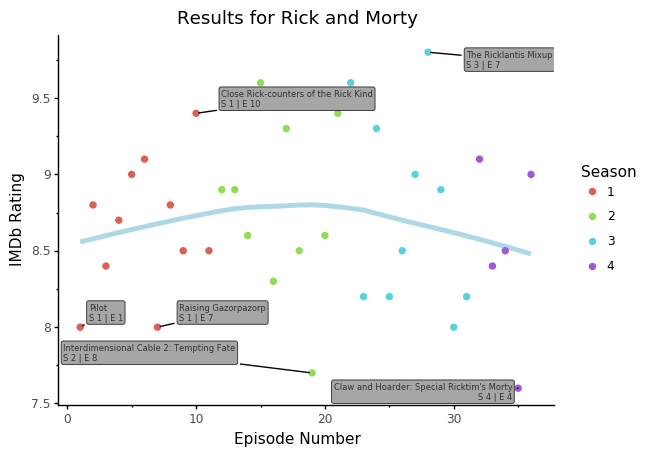

<ggplot: (-9223371907193281596)>

In [88]:
plot = (ggplot(df, aes(y='rating', x=df.index.tolist()))
    + geom_smooth(color='lightblue', size = 2)
    + geom_point(aes(color = 'factor(season)'), size = 2)
    + geom_label(aes(x = outlier_index,
                    y = df[df['outlier']==True]['rating'].values,
                    label = 'combined_labs'),
                data = df[df['outlier']==True], size = 6, show_legend = False, alpha = .7, fill = 'gray',
                adjust_text={'expand_points':(1.5, 1.5), 'expand_text':(2, 2), 'arrowprops': {'arrowstyle': '-'}})
    + labs(x = 'Episode Number', y = 'IMDb Rating', title = "Results for " + str(df['series'].unique()[0]), color = "Season")
    + theme_classic())
plot